In [1]:
import os
from crnn import CRNN
import torch
import torch.nn.functional as F
import torchvision
import dataset
from torch.autograd import Variable
import utils
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nh = 100
alphabet = '0123456789'
nclass = len(alphabet) + 1
nc = 1
mynet = CRNN(32, nc, nclass, nh)

In [3]:
converter = utils.strLabelConverter(alphabet)

In [4]:
mynet.load_state_dict(torch.load('/home/sherlock/Documents/express_recognition/data/model_save/telephone/tele3.pth'))
mynet = mynet.cuda()
mynet = mynet.eval()

In [5]:
root = '/home/sherlock/Documents/express_recognition/data/validation/'
img_root = root + 'telephone_data_3'
txt_root = root + 'telephone_label_validation_3.txt'

In [6]:
dset = dataset.Dataset(img_root=img_root, txt_root=txt_root)

In [7]:
print('All Valid Image number is {}'.format(len(dset)))

All Valid Image number is 301


In [ ]:
def get_acc():
    transformer = dataset.resizeNormalize((256, 32))
    num_correct = 0
    for i, img_path in enumerate(dset.image):
        image = Image.open(img_path).convert('L')
        image = transformer(image).cuda()
        image = image.view(1, *image.size())
        image = Variable(image)

        preds = mynet(image) # sequence_length x batch_size x n_classes
        _, preds = preds.max(2) # sequence_length x batch_size x 1
        preds = preds.view(-1) # sequence_length x 1
        preds_size = torch.IntTensor([preds.size(0)])
        raw_pred = converter.decode(preds.data, preds_size, raw=True)
        sim_pred = converter.decode(preds.data, preds_size, raw=False)
        if sim_pred == dset.label[i]:
            num_correct += 1
        else:
            pic = Image.open(img_path)
            plt.imshow(pic)
            plt.show()
            print(img_path.split('/')[-1])
            print('{} => {}'.format(raw_pred, sim_pred))
    print('total number is: {}'.format(num_correct))
    print('total accuracy: {:.6f}'.format(num_correct/len(dset)))

In [8]:
def decode(x):
    i = 0
    text = ''
    while i < len(x)-1:
        temp = x.cpu().data[i]
        if temp == 0:
            i += 1
        else:
            text += str(temp-1)
            if temp == x.cpu().data[i+1]:
                i += 2
            else:
                i += 1
    if i == len(x)-1:
        if x.cpu().data[i] != 0:
            text += str(x.cpu().data[i]-1)
    return text

In [9]:
def get_acc_new():
    transformer = dataset.resizeNormalize((256, 32))
    num_correct = 0
    new_correct = 0
    for j, img_path in enumerate(dset.image):
        image = Image.open(img_path).convert('L')
        image = transformer(image).cuda()
        image = image.view(1, *image.size())
        image = Variable(image)

        preds = mynet(image) # sequence_length x batch_size x n_classes
        _, preds = preds.max(2) # sequence_length x batch_size x 1
        preds = preds.view(-1) # sequence_length x 1
        preds_size = torch.IntTensor([preds.size(0)])
        raw_pred = converter.decode(preds.data, preds_size, raw=True)
        sim_pred = converter.decode(preds.data, preds_size, raw=False)
        my_pred = decode(preds)
        if sim_pred == dset.label[j]:
            num_correct += 1
        else:
            print('old error')
            pic = Image.open(img_path)
            plt.imshow(pic)
            plt.show()
            print('{} => {}'.format(raw_pred, sim_pred))
        if my_pred == dset.label[j]:
            new_correct += 1
        else:
            print('new error')
            pic = Image.open(img_path)
            plt.imshow(pic)
            plt.show()
            print('{} => {}'.format(raw_pred, my_pred))
        print('*'*10)
    print('old total number is: {}'.format(num_correct))
    print('new total number is: {}'.format(new_correct))
    print('old total accuracy: {:.6f}'.format(num_correct/len(dset)))
    print('new total accuracy: {:.6f}'.format(new_correct/len(dset)))

old error


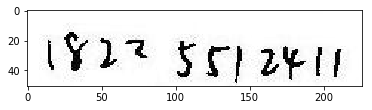

-------11--11------------------- => 11
new error


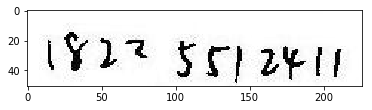

-------11--11------------------- => 11
**********
old error


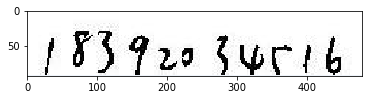

---11------1----1----1-----1111- => 11111
new error


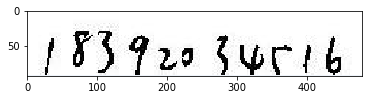

---11------1----1----1-----1111- => 111111
**********
old error


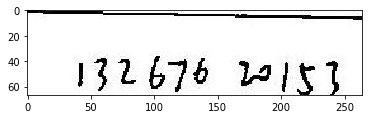

------------------------11------ => 1
new error


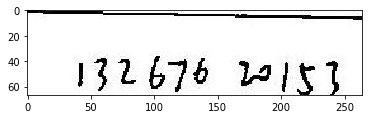

------------------------11------ => 1
**********
old error


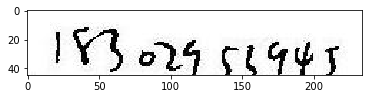

-------------------------------- => 
new error


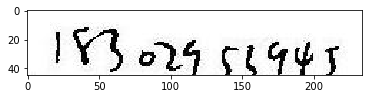

-------------------------------- => 
**********
old error


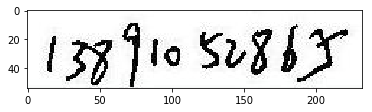

--------1--------------1-------- => 11
new error


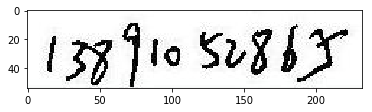

--------1--------------1-------- => 11
**********
old error


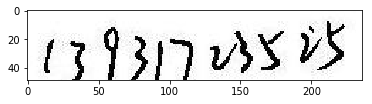

---111-1------111--------------- => 111
new error


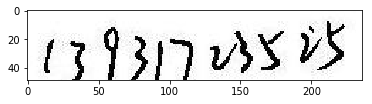

---111-1------111--------------- => 11111
**********
old error


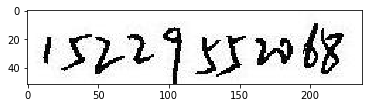

--------------11------------8--- => 18
new error


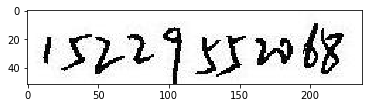

--------------11------------8--- => 18
**********
old error


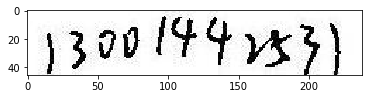

1--1-------11---------------1--- => 1111
new error


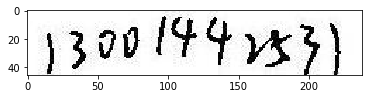

1--1-------11---------------1--- => 1111
**********
old error


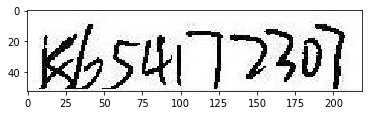

--------------111111-----------4 => 14
new error


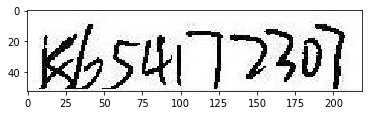

--------------111111-----------4 => 1114
**********
old error


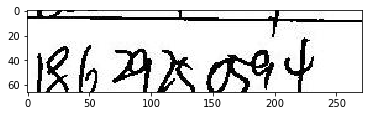

-----11---------------------111- => 11
new error


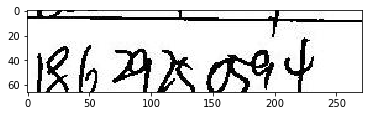

-----11---------------------111- => 111
**********
old error


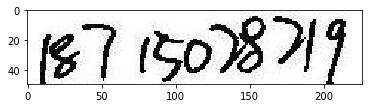

---5---111----------88---1--11-- => 51811
new error


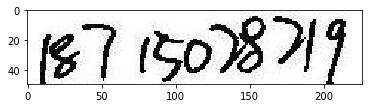

---5---111----------88---1--11-- => 511811
**********
old error


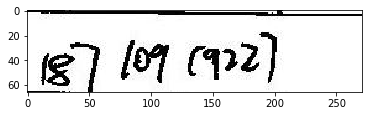

------1-------1--------111111-1- => 1111
new error


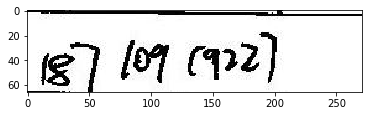

------1-------1--------111111-1- => 111111
**********
old error


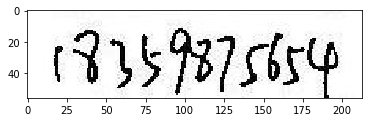

---1------------------------1--- => 11
new error


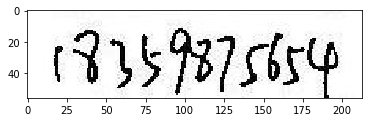

---1------------------------1--- => 11
**********
old error


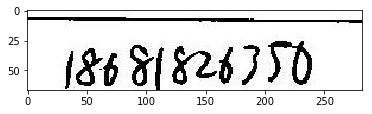

--1-1--1-----------------11111-- => 1111
new error


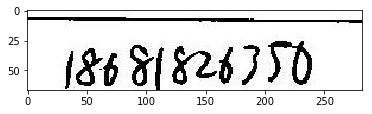

--1-1--1-----------------11111-- => 111111
**********
old error


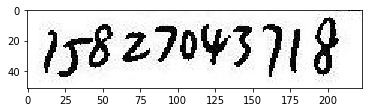

----------------------111--1---- => 11
new error


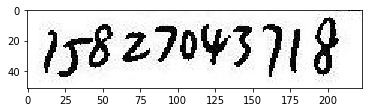

----------------------111--1---- => 111
**********
old error


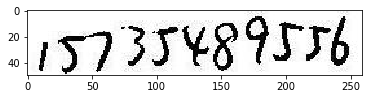

--1-----1----------------------4 => 114
new error


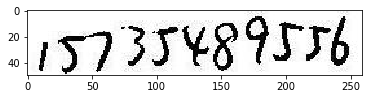

--1-----1----------------------4 => 114
**********
old error


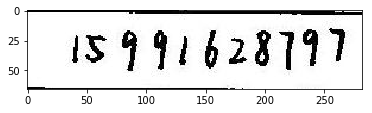

--1------1-111--111----1--1111-- => 111111
new error


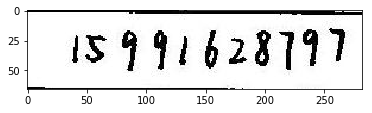

--1------1-111--111----1--1111-- => 111111111
**********
old error


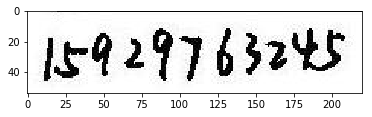

1-------1---111-11-------------- => 1111
new error


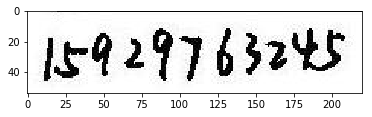

1-------1---111-11-------------- => 11111
**********
old error


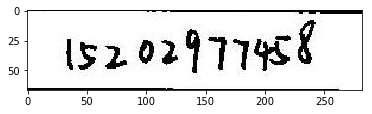

------------1-11-1---------1111- => 1111
new error


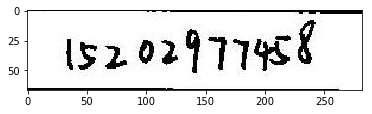

------------1-11-1---------1111- => 11111
**********
old error


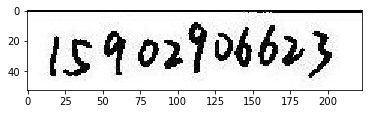

------------------------------1- => 1
new error


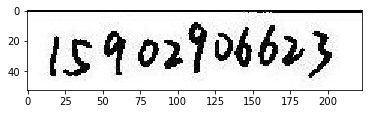

------------------------------1- => 1
**********
old error


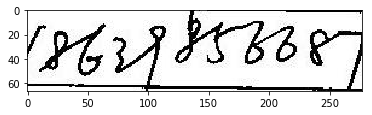

------------11-11-----------1--- => 111
new error


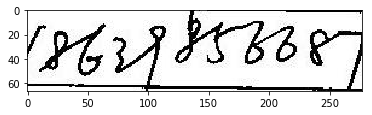

------------11-11-----------1--- => 111
**********
old error


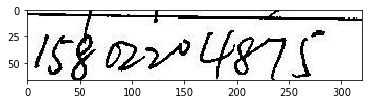

--------0---------------11111--- => 01
new error


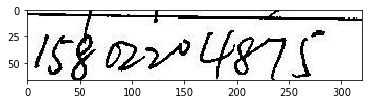

--------0---------------11111--- => 0111
**********
old error


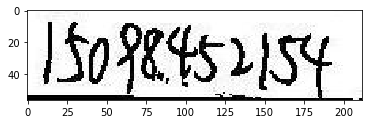

1--------------------1--5---1--- => 1151
new error


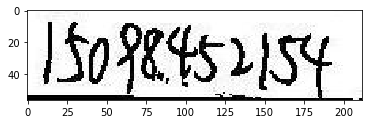

1--------------------1--5---1--- => 1151
**********
old error


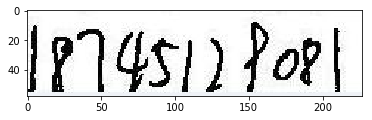

-111------------111---------1--- => 111
new error


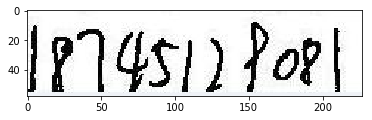

-111------------111---------1--- => 11111
**********
old error


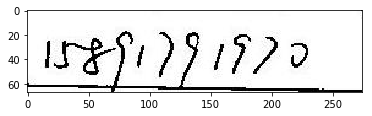

--------------111---111--1-1111- => 1111
new error


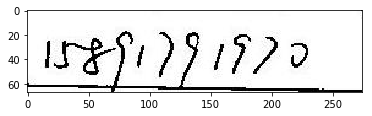

--------------111---111--1-1111- => 1111111
**********
old error


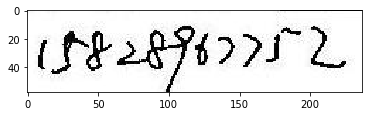

----------------1---1-1111------ => 111
new error


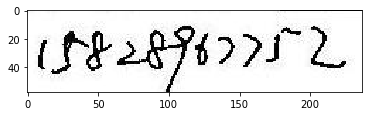

----------------1---1-1111------ => 1111
**********
old error


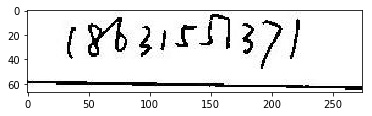

---------1---11---1------111111- => 1111
new error


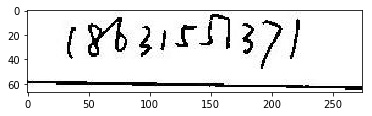

---------1---11---1------111111- => 111111
**********
old error


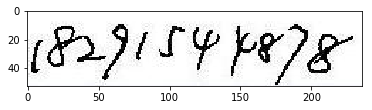

-------------------------------- => 
new error


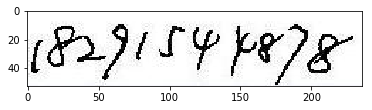

-------------------------------- => 
**********
old error


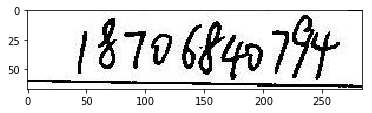

----------11---------0------7-1- => 1071
new error


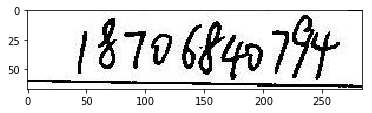

----------11---------0------7-1- => 1071
**********
old error


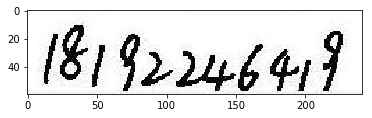

------1-1-------------------1--- => 111
new error


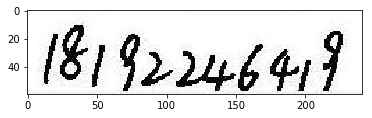

------1-1-------------------1--- => 111
**********
old error


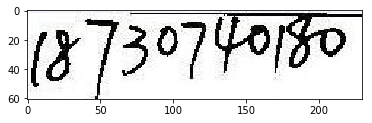

----11111-------11-1------------ => 111
new error


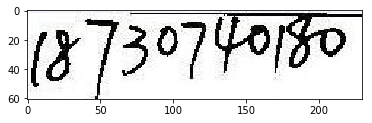

----11111-------11-1------------ => 11111
**********
old error


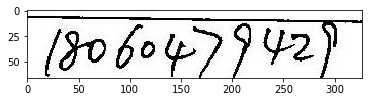

-------------1------------------ => 1
new error


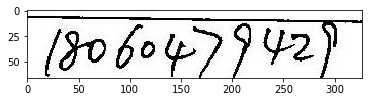

-------------1------------------ => 1
**********
old error


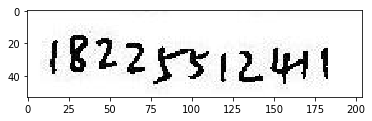

---1----1---------------------1- => 111
new error


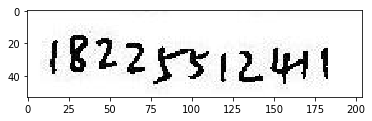

---1----1---------------------1- => 111
**********
old error


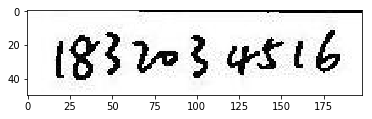

--------------11----------1----1 => 111
new error


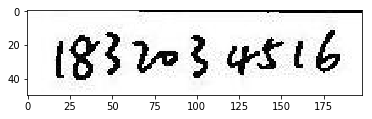

--------------11----------1----1 => 111
**********
old error


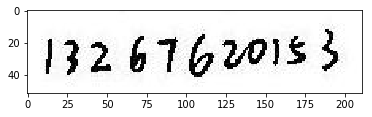

-----1----1---1----------------- => 111
new error


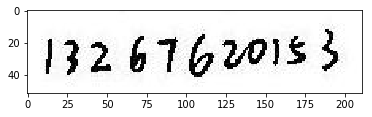

-----1----1---1----------------- => 111
**********
old error


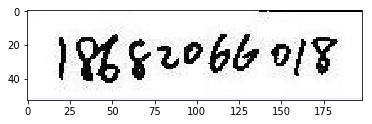

------------------------------1- => 1
new error


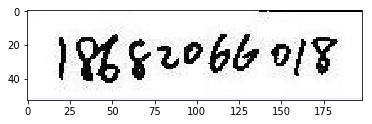

------------------------------1- => 1
**********
old error


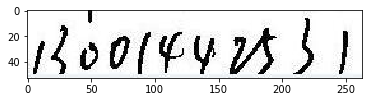

----------------------------1--1 => 11
new error


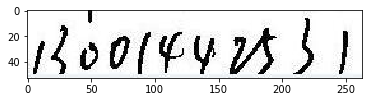

----------------------------1--1 => 11
**********
old error


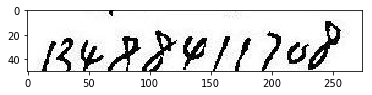

-------1------------1----------- => 11
new error


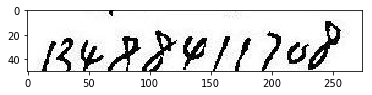

-------1------------1----------- => 11
**********
old error


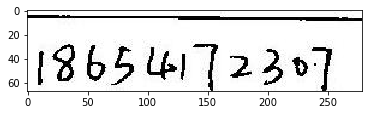

--------------11111---------11-- => 11
new error


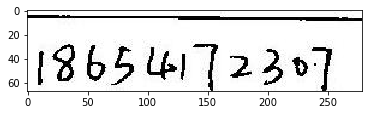

--------------11111---------11-- => 1111
**********
old error


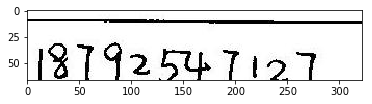

------1--1---1--111-111111--1--- => 111111
new error


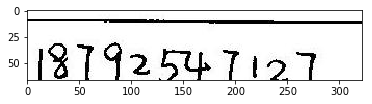

------1--1---1--111-111111--1--- => 111111111
**********
old error


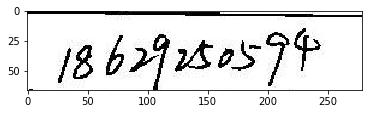

---------------------------1111- => 1
new error


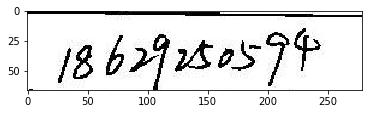

---------------------------1111- => 11
**********
old error


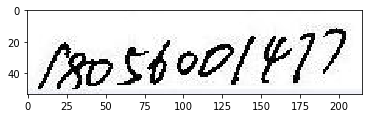

---------------------------11--- => 1
new error


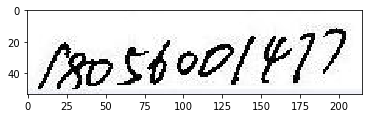

---------------------------11--- => 1
**********
old error


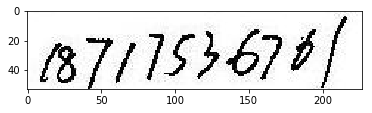

----------1----------------111-- => 11
new error


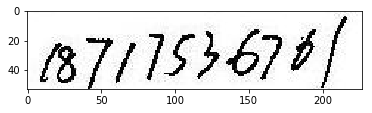

----------1----------------111-- => 111
**********
old error


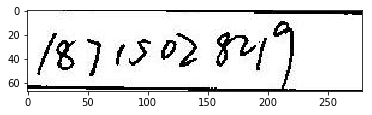

------11111----------11--11111-- => 111
new error


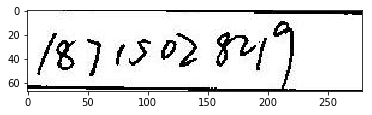

------11111----------11--11111-- => 1111111
**********
old error


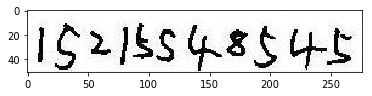

--11---------------------------- => 1
new error


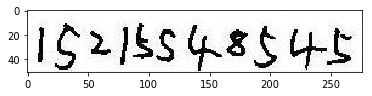

--11---------------------------- => 1
**********
old error


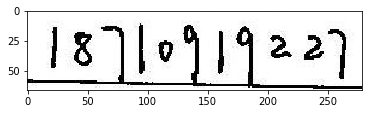

---111-1-11-1-11-1-1111-----1--1 => 111111111
new error


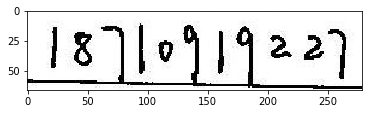

---111-1-11-1-11-1-1111-----1--1 => 11111111111
**********
old error


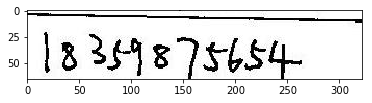

--1----------------------1--11-- => 111
new error


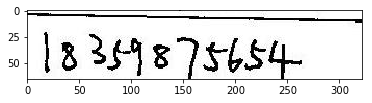

--1----------------------1--11-- => 111
**********
old error


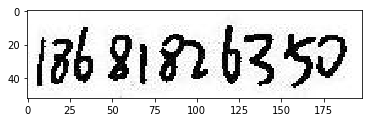

----1-------1----1----------5--4 => 11154
new error


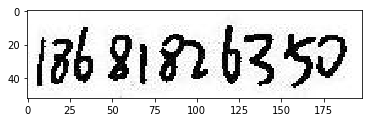

----1-------1----1----------5--4 => 11154
**********
old error


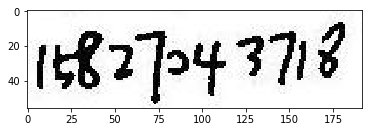

----5-----111---------11-----1-- => 5111
new error


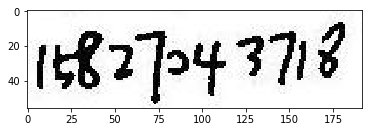

----5-----111---------11-----1-- => 51111
**********
old error


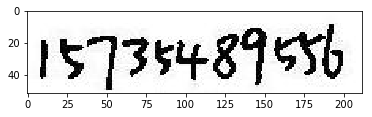

------1-----------5------------- => 15
new error


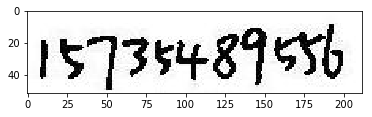

------1-----------5------------- => 15
**********
old error


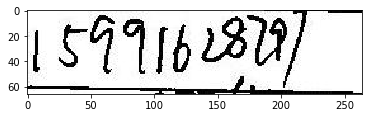

11----1111-11------------111111- => 1111
new error


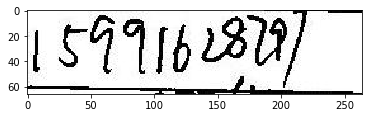

11----1111-11------------111111- => 1111111
**********
old error


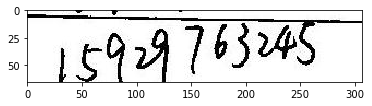

----11--------1-1--1--------1--- => 11111
new error


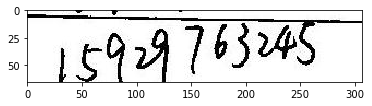

----11--------1-1--1--------1--- => 11111
**********
old error


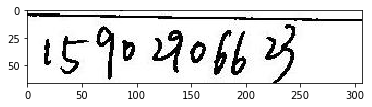

----------1----------------1111- => 11
new error


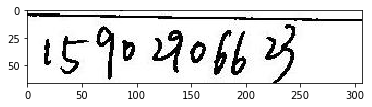

----------1----------------1111- => 111
**********
old error


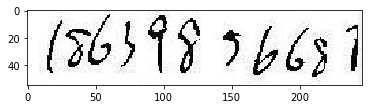

--1------1------11-------------- => 111
new error


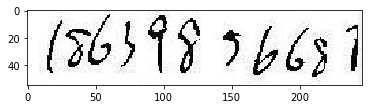

--1------1------11-------------- => 111
**********
old error


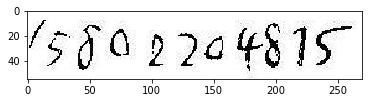

---------------------------1-11- => 11
new error


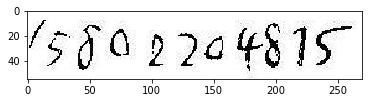

---------------------------1-11- => 11
**********
old error


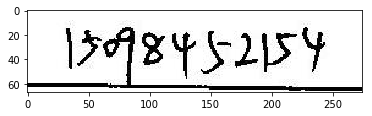

1-1111---------------------1111- => 111
new error


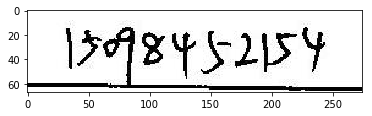

1-1111---------------------1111- => 11111
**********
old error


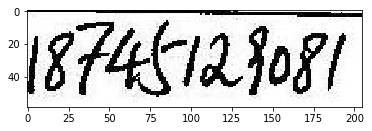

1---------------------------11-- => 11
new error


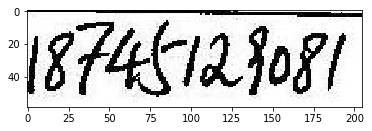

1---------------------------11-- => 11
**********
old error


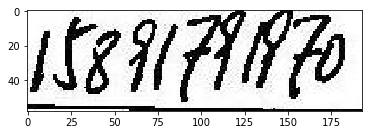

-----0-0--11--11-1-71-1-1------1 => 0011171111
new error


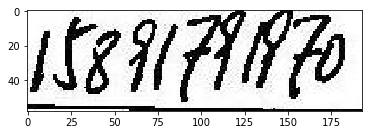

-----0-0--11--11-1-71-1-1------1 => 0011171111
**********
old error


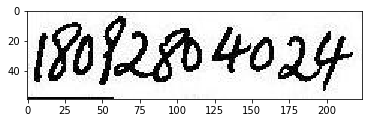

-------------------------------- => 
new error


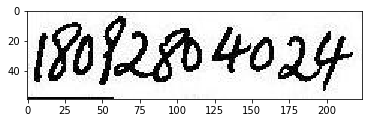

-------------------------------- => 
**********
old error


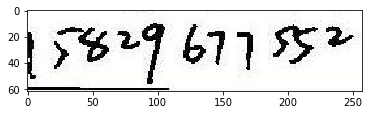

-----------111--1111111----11--- => 111
new error


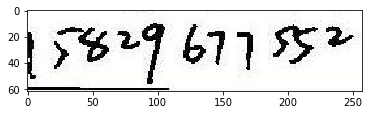

-----------111--1111111----11--- => 1111111
**********
old error


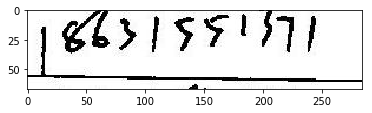

-------11--11-1---1111111--1111- => 11111
new error


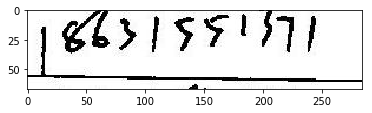

-------11--11-1---1111111--1111- => 111111111
**********
old error


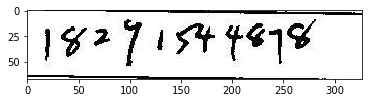

1------1111-11-----11------1111- => 11111
new error


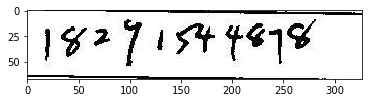

1------1111-11-----11------1111- => 1111111
**********
old error


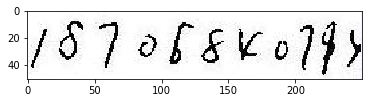

-----1-111---1------------------ => 111
new error


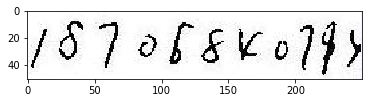

-----1-111---1------------------ => 1111
**********
old error


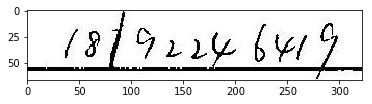

--------1-------------------1--- => 11
new error


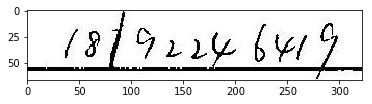

--------1-------------------1--- => 11
**********
old error


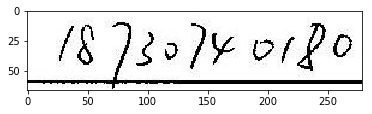

--1-11---1-------11111--11------ => 11111
new error


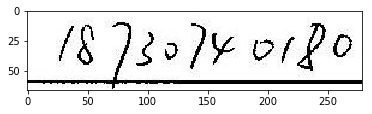

--1-11---1-------11111--11------ => 1111111
**********
old error


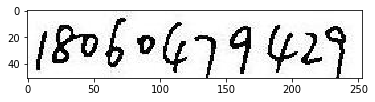

------------------1------------4 => 14
new error


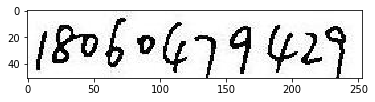

------------------1------------4 => 14
**********
old error


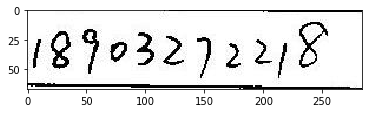

------1---------11111---1111111- => 111
new error


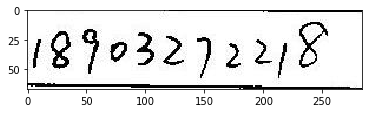

------1---------11111---1111111- => 11111111
**********
old error


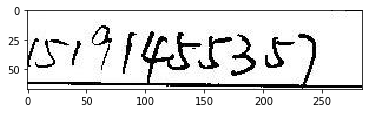

1----1--111----------------1111- => 1111
new error


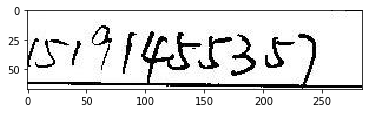

1----1--111----------------1111- => 111111
**********
old error


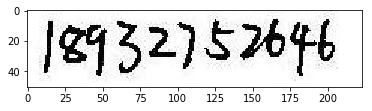

--------------111--------------- => 1
new error


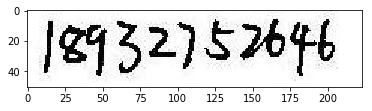

--------------111--------------- => 11
**********
old error


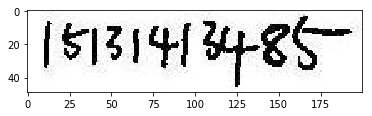

--------------------------1-1111 => 11
new error


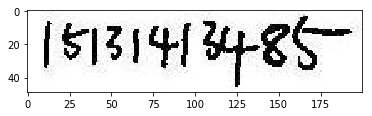

--------------------------1-1111 => 111
**********
old error


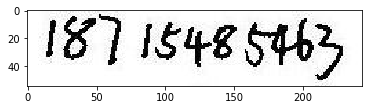

-------11-1--------------------- => 11
new error


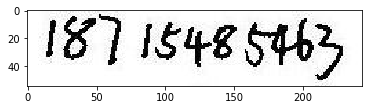

-------11-1--------------------- => 11
**********
old error


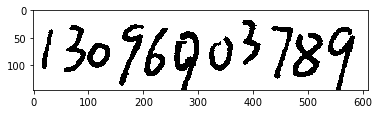

-------------------------------- => 
new error


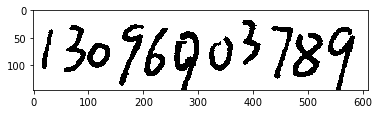

-------------------------------- => 
**********
old error


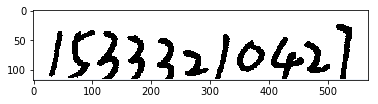

1---------------1-----------1--1 => 1111
new error


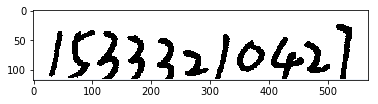

1---------------1-----------1--1 => 1111
**********
old error


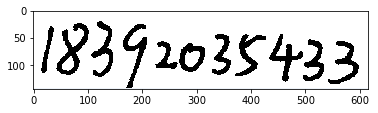

-------------------------------- => 
new error


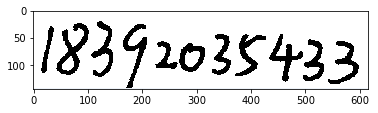

-------------------------------- => 
**********
old error


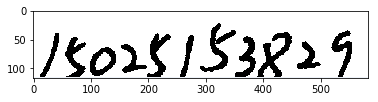

1------------1-1---------------- => 111
new error


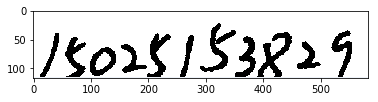

1------------1-1---------------- => 111
**********
old error


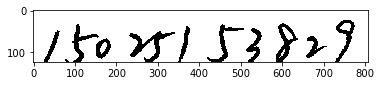

1------------1111--------------4 => 114
new error


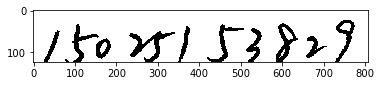

1------------1111--------------4 => 1114
**********
old error


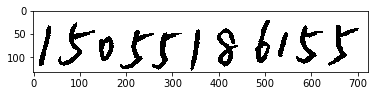

--------11---11-1-----1--------- => 1111
new error


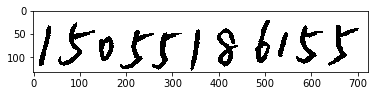

--------11---11-1-----1--------- => 1111
**********
old error


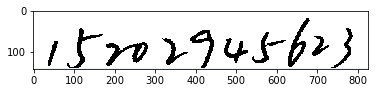

--1--1----------------------1--- => 111
new error


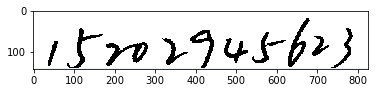

--1--1----------------------1--- => 111
**********
old error


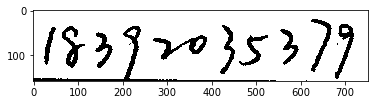

--11-----111------------1-1-11-4 => 111114
new error


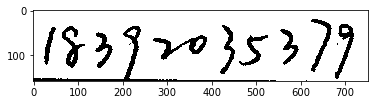

--11-----111------------1-1-11-4 => 1111114
**********
old error


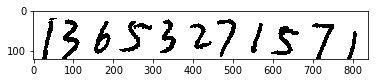

--1---------------11-11-----1--1 => 11111
new error


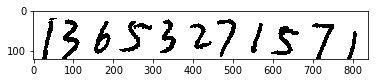

--1---------------11-11-----1--1 => 11111
**********
old error


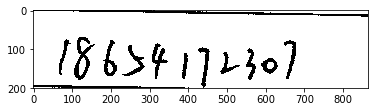

-11-----------11--------11--1--- => 1111
new error


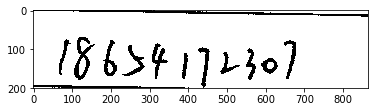

-11-----------11--------11--1--- => 1111
**********
old error


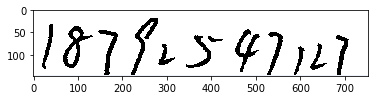

------1-1--111---------1111--1-- => 11111
new error


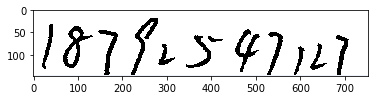

------1-1--111---------1111--1-- => 1111111
**********
old error


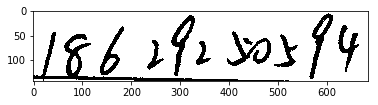

--1--1111--111-111-------11----8 => 111118
new error


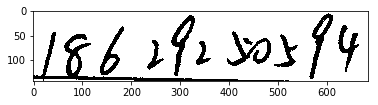

--1--1111--111-111-------11----8 => 111111118
**********
old error


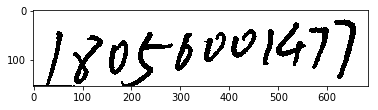

1-------------------------111--1 => 111
new error


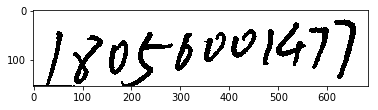

1-------------------------111--1 => 1111
**********
old error


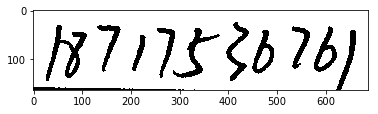

1----1111111----------0--------1 => 1101
new error


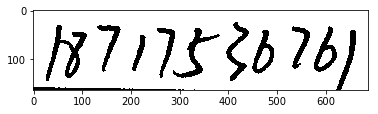

1----1111111----------0--------1 => 1111101
**********
old error


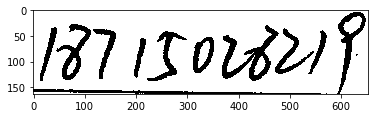

-----1111111-----1---------11--8 => 1118
new error


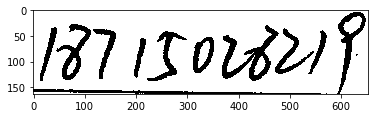

-----1111111-----1---------11--8 => 1111118
**********
old error


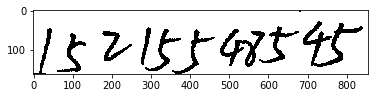

----------------------------7--- => 7
new error


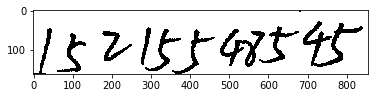

----------------------------7--- => 7
**********
old error


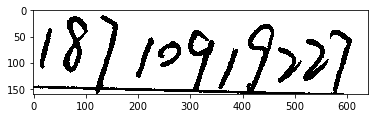

------111111-----111--------1--- => 111
new error


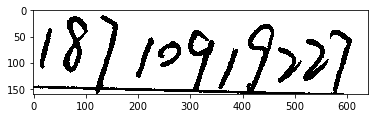

------111111-----111--------1--- => 111111
**********
old error


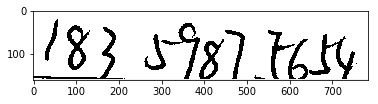

--11---11--1-------1111--------- => 1111
new error


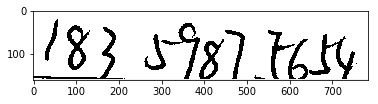

--11---11--1-------1111--------- => 11111
**********
old error


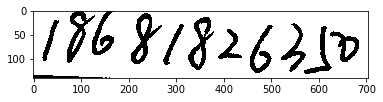

-----------11-1------------1---8 => 1118
new error


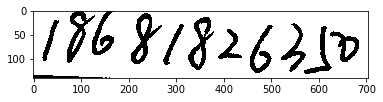

-----------11-1------------1---8 => 1118
**********
old error


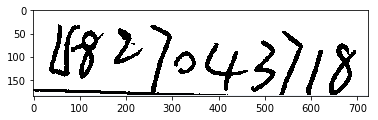

----0------11------------------- => 01
new error


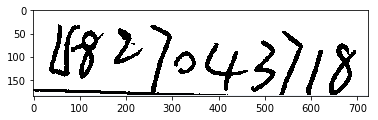

----0------11------------------- => 01
**********
old error


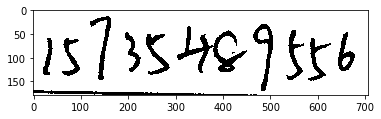

--1--111-11--------------------4 => 1114
new error


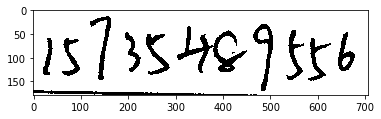

--1--111-11--------------------4 => 11114
**********
old error


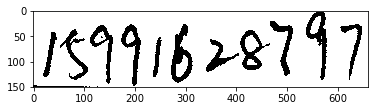

--1----------1---------1---111-- => 1111
new error


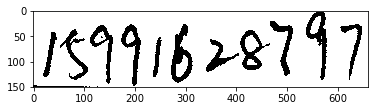

--1----------1---------1---111-- => 11111
**********
old error


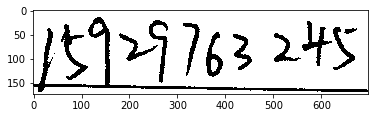

11-----------1-11---111--------- => 1111
new error


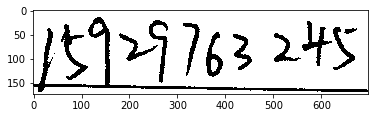

11-----------1-11---111--------- => 11111
**********
old error


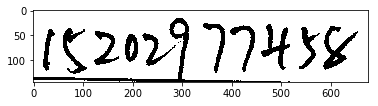

----------1---111111------------ => 11
new error


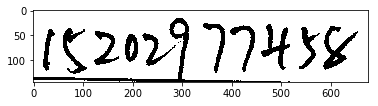

----------1---111111------------ => 1111
**********
old error


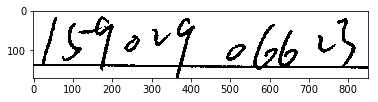

----------1---111-----0--------- => 110
new error


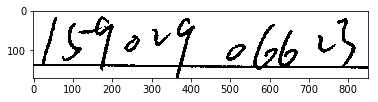

----------1---111-----0--------- => 1110
**********
old error


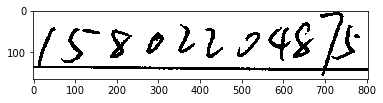

-------------------------------8 => 8
new error


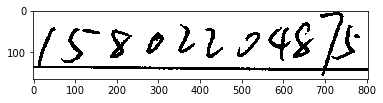

-------------------------------8 => 8
**********
old error


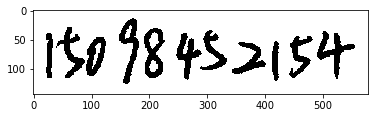

----------1-----------------1--- => 11
new error


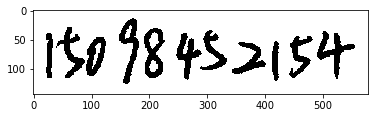

----------1-----------------1--- => 11
**********
old error


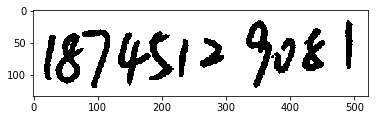

--5----1-------11-1---------1--- => 51111
new error


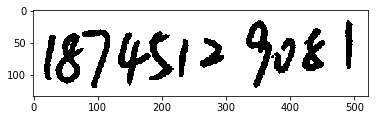

--5----1-------11-1---------1--- => 51111
**********
old error


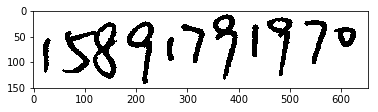

--1---8-----111111-11111111111-- => 1811
new error


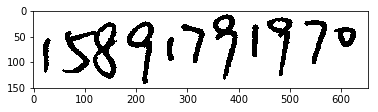

--1---8-----111111-11111111111-- => 18111111111
**********
old error


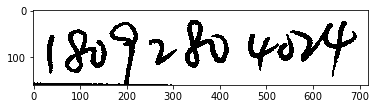

--1--5----11----5--------------- => 1515
new error


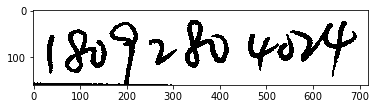

--1--5----11----5--------------- => 1515
**********
old error


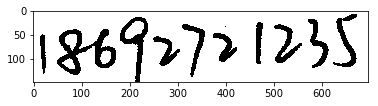

-1---------11-111--1111--------- => 1111
new error


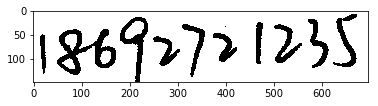

-1---------11-111--1111--------- => 111111
**********
old error


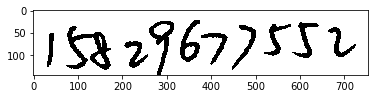

--1--------------1-------------- => 11
new error


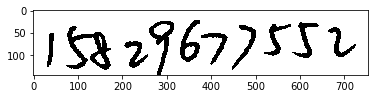

--1--------------1-------------- => 11
**********
old error


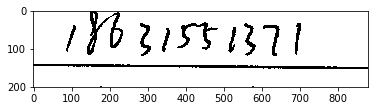

----------1-11-----------1--1--- => 1111
new error


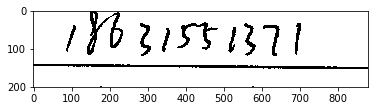

----------1-11-----------1--1--- => 1111
**********
old error


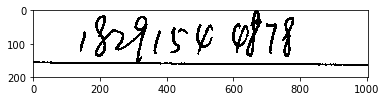

------------------------11111--- => 1
new error


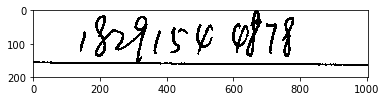

------------------------11111--- => 111
**********
old error


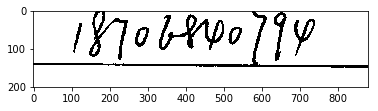

-------------1------11---11111-- => 111
new error


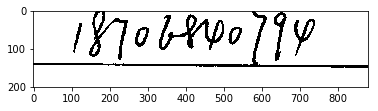

-------------1------11---11111-- => 11111
**********
old error


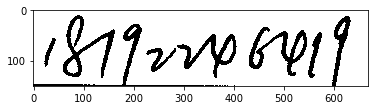

-----1----1-----------------111- => 111
new error


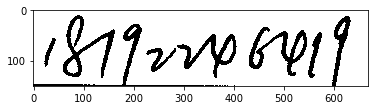

-----1----1-----------------111- => 1111
**********
old error


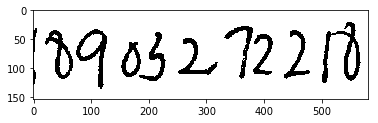

1---------------1---------11---8 => 1118
new error


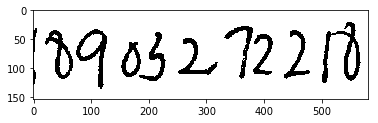

1---------------1---------11---8 => 1118
**********
old error


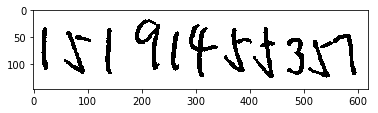

-------11----1--------------1--1 => 1111
new error


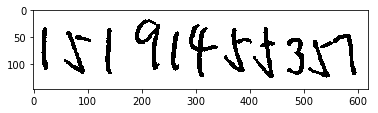

-------11----1--------------1--1 => 1111
**********
old error


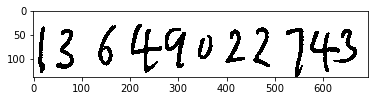

-1----------------------1-1----4 => 1114
new error


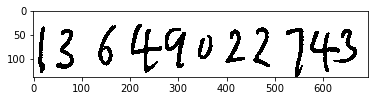

-1----------------------1-1----4 => 1114
**********
old error


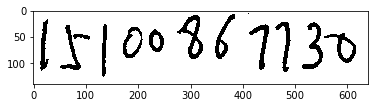

-------1---------11111-111------ => 111
new error


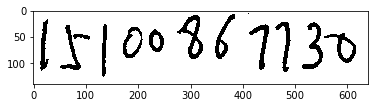

-------1---------11111-111------ => 111111
**********
old error


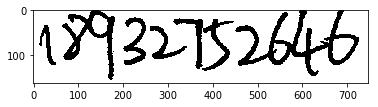

---1---------------0------------ => 10
new error


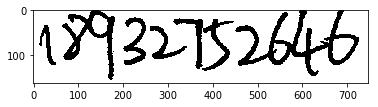

---1---------------0------------ => 10
**********
old error


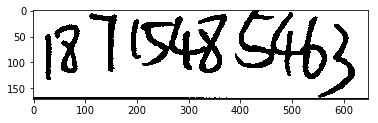

---11111111--------------------- => 1
new error


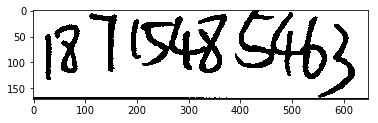

---11111111--------------------- => 1111
**********
old error


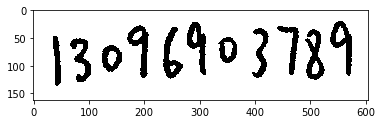

1--1--------1------------------- => 111
new error


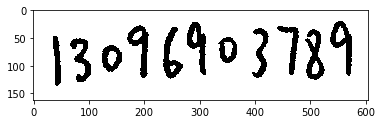

1--1--------1------------------- => 111
**********
old error


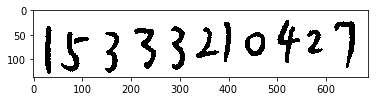

------------1------1--1--1111--1 => 11111
new error


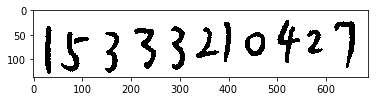

------------1------1--1--1111--1 => 111111
**********
old error


KeyboardInterrupt: 

In [10]:
get_acc_new()

In [13]:
def show_result(img_name):
    root = '/home/sherlock/Documents/express_recognition/data/train/telephone_1'
    img_path = os.path.join(root, img_name)
    transformer = dataset.resizeNormalize((256, 32))
    image = Image.open(img_path).convert('L')
    image = transformer(image).cuda()
    image = image.view(1, *image.size())
    image = Variable(image)
    
    mynet.eval()
    preds = mynet(image) # sequence_length x batch_size x n_classes
    _, preds = preds.max(2) # sequence_length x batch_size x 1
    preds = preds.view(-1) # sequence_length x 1
    preds_size = torch.IntTensor([preds.size(0)])
    raw_pred = converter.decode(preds.data, preds_size, raw=True)
    sim_pred = converter.decode(preds.data, preds_size, raw=False)
    pic = Image.open(img_path)
    plt.imshow(pic)
    plt.show()
    print('{} => {}'.format(raw_pred, sim_pred))

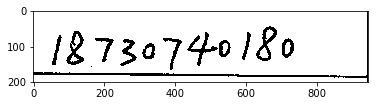

------------------------11111--- => 1


In [14]:
show_result('1_190_1_1.png')

In [ ]:
root = '/home/sherlock/Documents/express_recognition/data/validation/telephone_data'
img_path = os.path.join(root, '1_10_0_0.png')
transformer = dataset.resizeNormalize((256, 32))
image = Image.open(img_path).convert('L')
image = transformer(image).cuda()
image = image.view(1, *image.size())
image = Variable(image)

mynet.eval()
preds = mynet(image) # preds sequence_length x batch_size x n_classes

In [ ]:
preds = preds.squeeze(1)

In [ ]:
preds = F.softmax(preds)
prob, label = torch.max(preds, 1)

In [ ]:
tele = ''
for i in range(label.size(0)):
    if prob[i].cpu().data[0] > 0.9:
        if label[i].cpu().data[0] == 0:
            tele += '-'
        else:
            tele += str(label[i].cpu().data[0]-1)

In [ ]:
for i in range(preds.size(0)):
    label = preds.cpu().data[i, :]
    label = label.numpy()
    plt.plot(label)
    plt.title('{}'.format(i))
    plt.show()

In [ ]:
all_file_name = os.listdir('/home/sherlock/Documents/express_recognition/data/validation/telephone/')

for img in all_file_name:
    show_result(img)
    print()